# Clustering 

In [1]:
import sys
sys.version

'3.10.5 (main, Jun  6 2022, 18:49:26) [GCC 12.1.0]'

## Some utilities

In [3]:
import os
from pathlib import Path

CHART_DIR = Path("charts")
if not CHART_DIR.exists():
    CHART_DIR.mkdir()
    
DATA_DIR = Path("data")
if not DATA_DIR.exists():
    raise Exception(f"Data directory {CHART_DIR.absolute()} not found")

In [4]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import numpy as np
import scipy

DPI = 300

def save_png(name):
    filename = f"B09124_06_{name}.png"
    plt.savefig(str(CHART_DIR / filename), bbox_inches="tight")

## Converting raw text into a bag of words 

In [5]:
!pip install sklearn

Defaulting to user installation because normal site-packages is not writeable


In [6]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=1)
print(vectorizer)

CountVectorizer()


In [7]:
content = ["How to format my hard disk", 
           " Hard disk format  problems "]
X = vectorizer.fit_transform(content)
vectorizer.get_feature_names()

/home/shreyam/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['disk', 'format', 'hard', 'how', 'my', 'problems', 'to']

In [8]:
content = ["How to format my hard disk", 
           " Hard disk format  problems "]
X = vectorizer.fit_transform(content)
vectorizer.get_feature_names_out()

array(['disk', 'format', 'hard', 'how', 'my', 'problems', 'to'],
      dtype=object)

In [11]:
print(X.toarray())

[[1 1 1 1 1 0 1]
 [1 1 1 0 0 1 0]]


In [13]:
print(X.toarray().transpose()) 

[[1 1]
 [1 1]
 [1 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]]


## Counting words

In [16]:
TOY_DIR = DATA_DIR / "toy"
posts = [p.read_text() for p in TOY_DIR.iterdir()]

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=1) 
vectorizer

CountVectorizer()

In [17]:
X_train = vectorizer.fit_transform(posts)
num_samples, num_features = X_train.shape
print(f"#samples: {num_samples}, #features: {num_features}")

#samples: 5, #features: 25


In [18]:
print(vectorizer.get_feature_names_out())

['about' 'actually' 'capabilities' 'contains' 'data' 'databases' 'images'
 'imaging' 'interesting' 'is' 'it' 'learning' 'machine' 'most' 'much'
 'not' 'permanently' 'post' 'provide' 'save' 'storage' 'store' 'stuff'
 'this' 'toy']


In [19]:
new_post = "imaging databases"
new_post_vec = vectorizer.transform([new_post]) 
print(new_post_vec)

  (0, 5)	1
  (0, 7)	1


In [20]:
print(new_post_vec.toarray())

[[0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [21]:
def dist_raw(v1, v2): 
    delta = v1-v2
    return scipy.linalg.norm(delta.toarray()) 

In [24]:
def best_post(X, new_vec, dist_func):
    best_doc = None
    best_dist = float('inf')
    best_i = None
    for i, post in enumerate(posts):
        if post == new_post: 
            continue 
        post_vec = X.getrow(i) 
        d = dist_func(post_vec, new_vec) 
        print(f"=== Post {i} with dist={d:.2f}:\n    '{post}'") 
        if d < best_dist: 
            best_dist = d 
            best_i = i
    print(f"\n==> Best post is {best_i} with dist={best_dist:.2f}")

In [25]:
best_post(X_train, new_post_vec, dist_raw)

=== Post 0 with dist=4.00:
    'This is a toy post about machine learning. Actually, it contains not much interesting stuff.'
=== Post 1 with dist=1.73:
    'Imaging databases provide storage capabilities.'
=== Post 2 with dist=2.00:
    'Most imaging databases save images permanently.
'
=== Post 3 with dist=1.41:
    'Imaging databases store data.'
=== Post 4 with dist=5.10:
    'Imaging databases store data. Imaging databases store data. Imaging databases store data.'

==> Best post is 3 with dist=1.41


In [26]:
X_train.getrow(3).toarray()

array([[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0]])

In [27]:
X_train.getrow(4).toarray()

array([[0, 0, 0, 0, 3, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
        0, 0, 0]])

## Normalizing word count vectors 

In [28]:
def dist_norm(v1, v2): 
    v1_normalized = v1 / scipy.linalg.norm(v1.toarray()) 
    v2_normalized = v2 / scipy.linalg.norm(v2.toarray()) 
    delta = v1_normalized - v2_normalized  
    return scipy.linalg.norm(delta.toarray()) 

best_post(X_train, new_post_vec, dist_norm)

=== Post 0 with dist=1.41:
    'This is a toy post about machine learning. Actually, it contains not much interesting stuff.'
=== Post 1 with dist=0.86:
    'Imaging databases provide storage capabilities.'
=== Post 2 with dist=0.92:
    'Most imaging databases save images permanently.
'
=== Post 3 with dist=0.77:
    'Imaging databases store data.'
=== Post 4 with dist=0.77:
    'Imaging databases store data. Imaging databases store data. Imaging databases store data.'

==> Best post is 3 with dist=0.77


## Removing less important words 

In [29]:
vect_engl = CountVectorizer(min_df=1, stop_words='english')
print(sorted(vect_engl.get_stop_words())[0:20])

['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst']


In [30]:
X_train_engl = vect_engl.fit_transform(posts)
num_samples_engl, num_features_engl = X_train_engl.shape
print(f"#samples: {num_samples_engl}, #features: {num_features_engl}")
print(vect_engl.get_feature_names())

#samples: 5, #features: 18
['actually', 'capabilities', 'contains', 'data', 'databases', 'images', 'imaging', 'interesting', 'learning', 'machine', 'permanently', 'post', 'provide', 'save', 'storage', 'store', 'stuff', 'toy']


In [31]:
new_post_vec_engl = vect_engl.transform([new_post]) 
print(new_post_vec_engl)

  (0, 4)	1
  (0, 6)	1


In [32]:
best_post(X_train_engl, new_post_vec_engl, dist_norm)

=== Post 0 with dist=1.41:
    'This is a toy post about machine learning. Actually, it contains not much interesting stuff.'
=== Post 1 with dist=0.86:
    'Imaging databases provide storage capabilities.'
=== Post 2 with dist=0.86:
    'Most imaging databases save images permanently.
'
=== Post 3 with dist=0.77:
    'Imaging databases store data.'
=== Post 4 with dist=0.77:
    'Imaging databases store data. Imaging databases store data. Imaging databases store data.'

==> Best post is 3 with dist=0.77


## Stemming

In [33]:
!pip install nltk

Defaulting to user installation because normal site-packages is not writeable


In [34]:
import nltk.stem

In [35]:
s = nltk.stem.SnowballStemmer('english')
print(s.stem("graphics"))
print(s.stem("imaging"))
print(s.stem("image"))
print(s.stem("imagination"))
print(s.stem("imagine"))
print(s.stem("buys"))
print(s.stem("buying"))
print(s.stem("bought"))

graphic
imag
imag
imagin
imagin
buy
buy
bought


In [37]:
english_stemmer = nltk.stem.SnowballStemmer('english')
class StemmedCountVectorizer(CountVectorizer): 
    def build_analyzer(self): 
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: (english_stemmer.stem(w) for w in  analyzer(doc))

vect_engl_stem = StemmedCountVectorizer(min_df=1, stop_words='english')        
print(vect_engl_stem)

StemmedCountVectorizer(stop_words='english')


In [38]:
X_train_engl_stem = vect_engl_stem.fit_transform(posts)
num_samples_engl_stem, num_features_engl_stem = X_train_engl_stem.shape
print(f"#samples: {num_samples_engl_stem}, #features: {num_features_engl_stem}")
print(vect_engl_stem.get_feature_names())

#samples: 5, #features: 17
['actual', 'capabl', 'contain', 'data', 'databas', 'imag', 'interest', 'learn', 'machin', 'perman', 'post', 'provid', 'save', 'storag', 'store', 'stuff', 'toy']


In [39]:
new_post_vec_engl_stem = vect_engl_stem.transform([new_post]) 
print(new_post_vec_engl_stem)

best_post(X_train_engl_stem, new_post_vec_engl_stem, dist_norm)

  (0, 4)	1
  (0, 5)	1
=== Post 0 with dist=1.41:
    'This is a toy post about machine learning. Actually, it contains not much interesting stuff.'
=== Post 1 with dist=0.86:
    'Imaging databases provide storage capabilities.'
=== Post 2 with dist=0.63:
    'Most imaging databases save images permanently.
'
=== Post 3 with dist=0.77:
    'Imaging databases store data.'
=== Post 4 with dist=0.77:
    'Imaging databases store data. Imaging databases store data. Imaging databases store data.'

==> Best post is 2 with dist=0.63


## Stop words on steroid using TFIDF

In [40]:
def tfidf(term, doc, corpus):
    tf = doc.count(term) / len(doc)
    idf = np.log(float(len(corpus)) / (len([d for d in corpus if term in d])))
    tf_idf = tf * idf
    print(f"term='{term}'   doc={doc} tf={tf:.2f}   idf={idf:.2f}")
    return tf_idf

# defining some documents
a, abb, abc = ["a"], ["a", "b", "b"], ["a", "b", "c"]

# defining some copora
D = [a, abb, abc]

print("=> tfidf={:.2f}".format(tfidf("a", a, D)))
print("=> tfidf={:.2f}".format(tfidf("a", abb, D)))
print("=> tfidf={:.2f}".format(tfidf("a", abc, D)))
print("=> tfidf={:.2f}".format(tfidf("b", abb, D)))
print("=> tfidf={:.2f}".format(tfidf("b", abc, D)))
print("=> tfidf={:.2f}".format(tfidf("c", abc, D)))

term='a'   doc=['a'] tf=1.00   idf=0.00
=> tfidf=0.00
term='a'   doc=['a', 'b', 'b'] tf=0.33   idf=0.00
=> tfidf=0.00
term='a'   doc=['a', 'b', 'c'] tf=0.33   idf=0.00
=> tfidf=0.00
term='b'   doc=['a', 'b', 'b'] tf=0.67   idf=0.41
=> tfidf=0.27
term='b'   doc=['a', 'b', 'c'] tf=0.33   idf=0.41
=> tfidf=0.14
term='c'   doc=['a', 'b', 'c'] tf=0.33   idf=1.10
=> tfidf=0.37


In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

class StemmedTfidfVectorizer(TfidfVectorizer):

    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: (english_stemmer.stem(w) for w in analyzer(doc))

vect_tfidf = StemmedTfidfVectorizer(#min_df=10, max_df=0.5,
                                    stop_words='english', decode_error='ignore')
print(vect_tfidf)

StemmedTfidfVectorizer(decode_error='ignore', stop_words='english')


In [42]:
X_train_tfidf = vect_tfidf.fit_transform(posts)
num_samples_tfidf, num_features_tfidf = X_train_tfidf.shape
print(f"#samples: {num_samples_tfidf}, #features: {num_features_tfidf}")
print(vect_tfidf.get_feature_names())

#samples: 5, #features: 17
['actual', 'capabl', 'contain', 'data', 'databas', 'imag', 'interest', 'learn', 'machin', 'perman', 'post', 'provid', 'save', 'storag', 'store', 'stuff', 'toy']


In [43]:
from sklearn.cluster import KMeans

seed = 2
np.random.seed(seed)  # to reproduce the data later on

num_clusters = 3


def plot_clustering(x, y, title, mx=None, ymax=None, xmin=None, km=None):
    plt.figure(num=None, figsize=(8, 6), dpi=DPI)
    if km:
        plt.scatter(x, y, s=30, c=km.predict(list(zip(x, y))))
    else:
        plt.scatter(x, y, s=30)

    plt.title(title)
    plt.xlabel("Occurrence word 1")
    plt.ylabel("Occurrence word 2")

    plt.autoscale(tight=True)
    plt.ylim(ymin=0, ymax=1)
    plt.xlim(xmin=0, xmax=1)
    plt.grid(True, linestyle='-', color='0.75')

    return plt

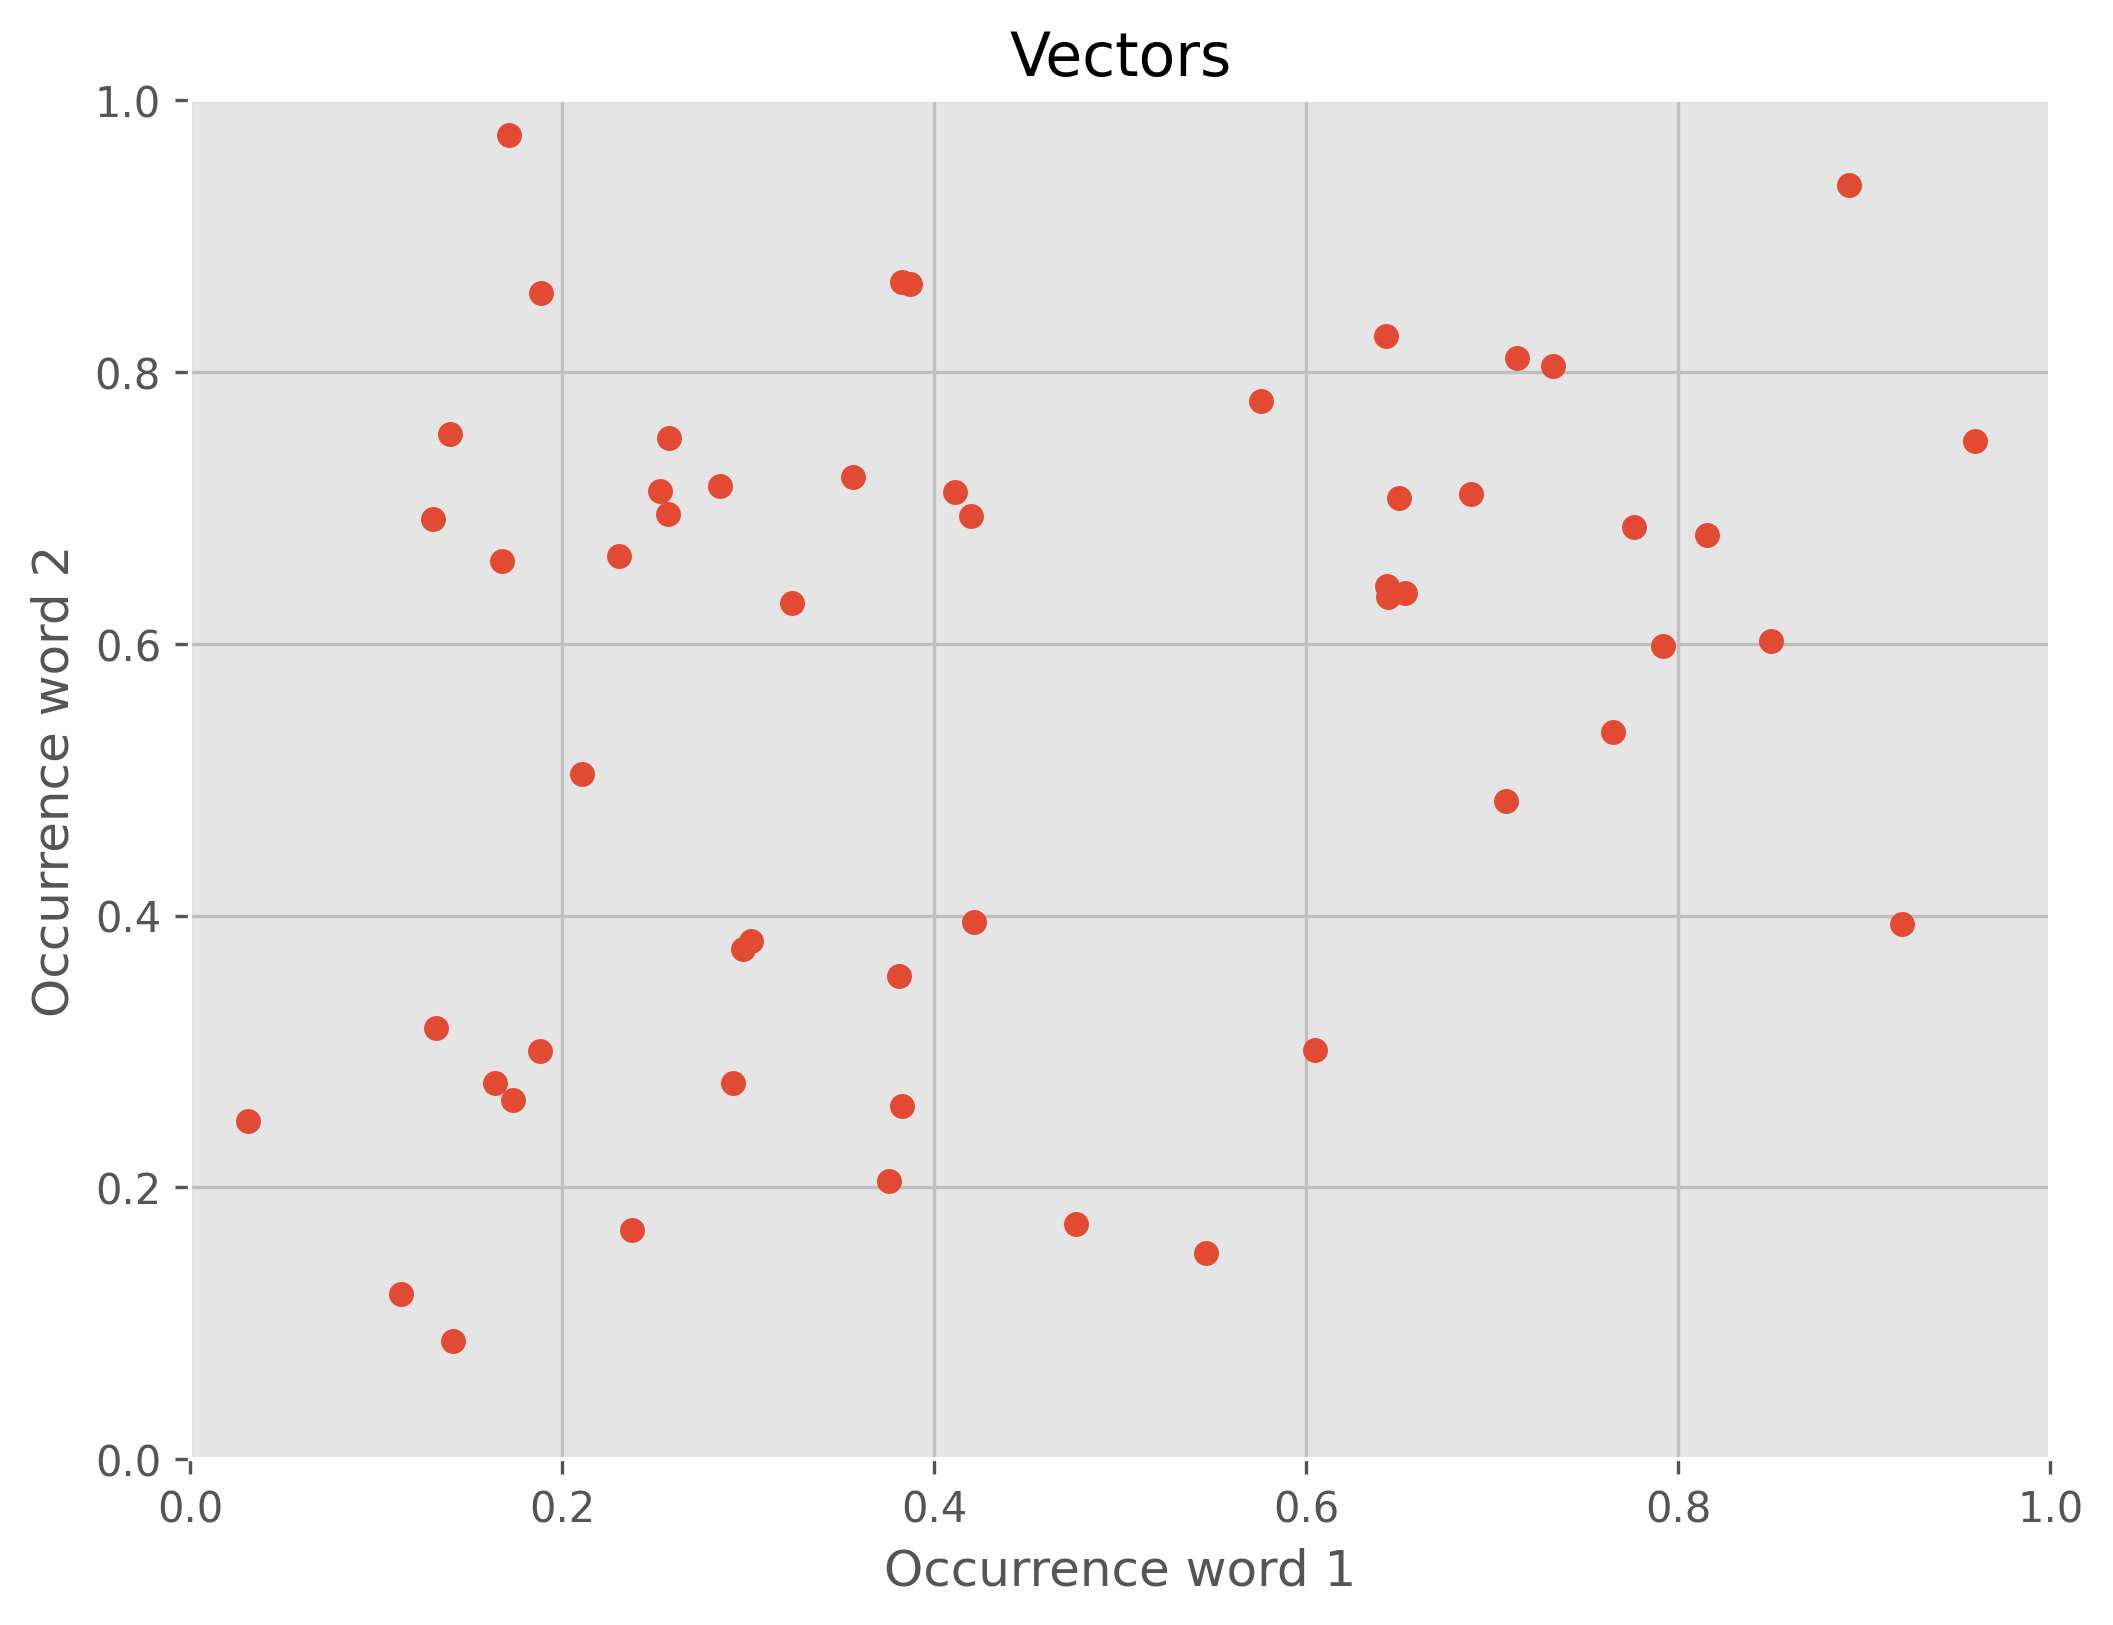

In [44]:
xw1 = scipy.stats.norm(loc=0.3, scale=.15).rvs(20)
yw1 = scipy.stats.norm(loc=0.3, scale=.15).rvs(20)

xw2 = scipy.stats.norm(loc=0.7, scale=.15).rvs(20)
yw2 = scipy.stats.norm(loc=0.7, scale=.15).rvs(20)

xw3 = scipy.stats.norm(loc=0.2, scale=.15).rvs(20)
yw3 = scipy.stats.norm(loc=0.8, scale=.15).rvs(20)

x = np.append(np.append(xw1, xw2), xw3)
y = np.append(np.append(yw1, yw2), yw3)

plot_clustering(x, y, "Vectors")
save_png("01_clustering_data")

## Clustering after 1st iteration 

Initialization complete
Iteration 0, inertia 4.748526747411677.


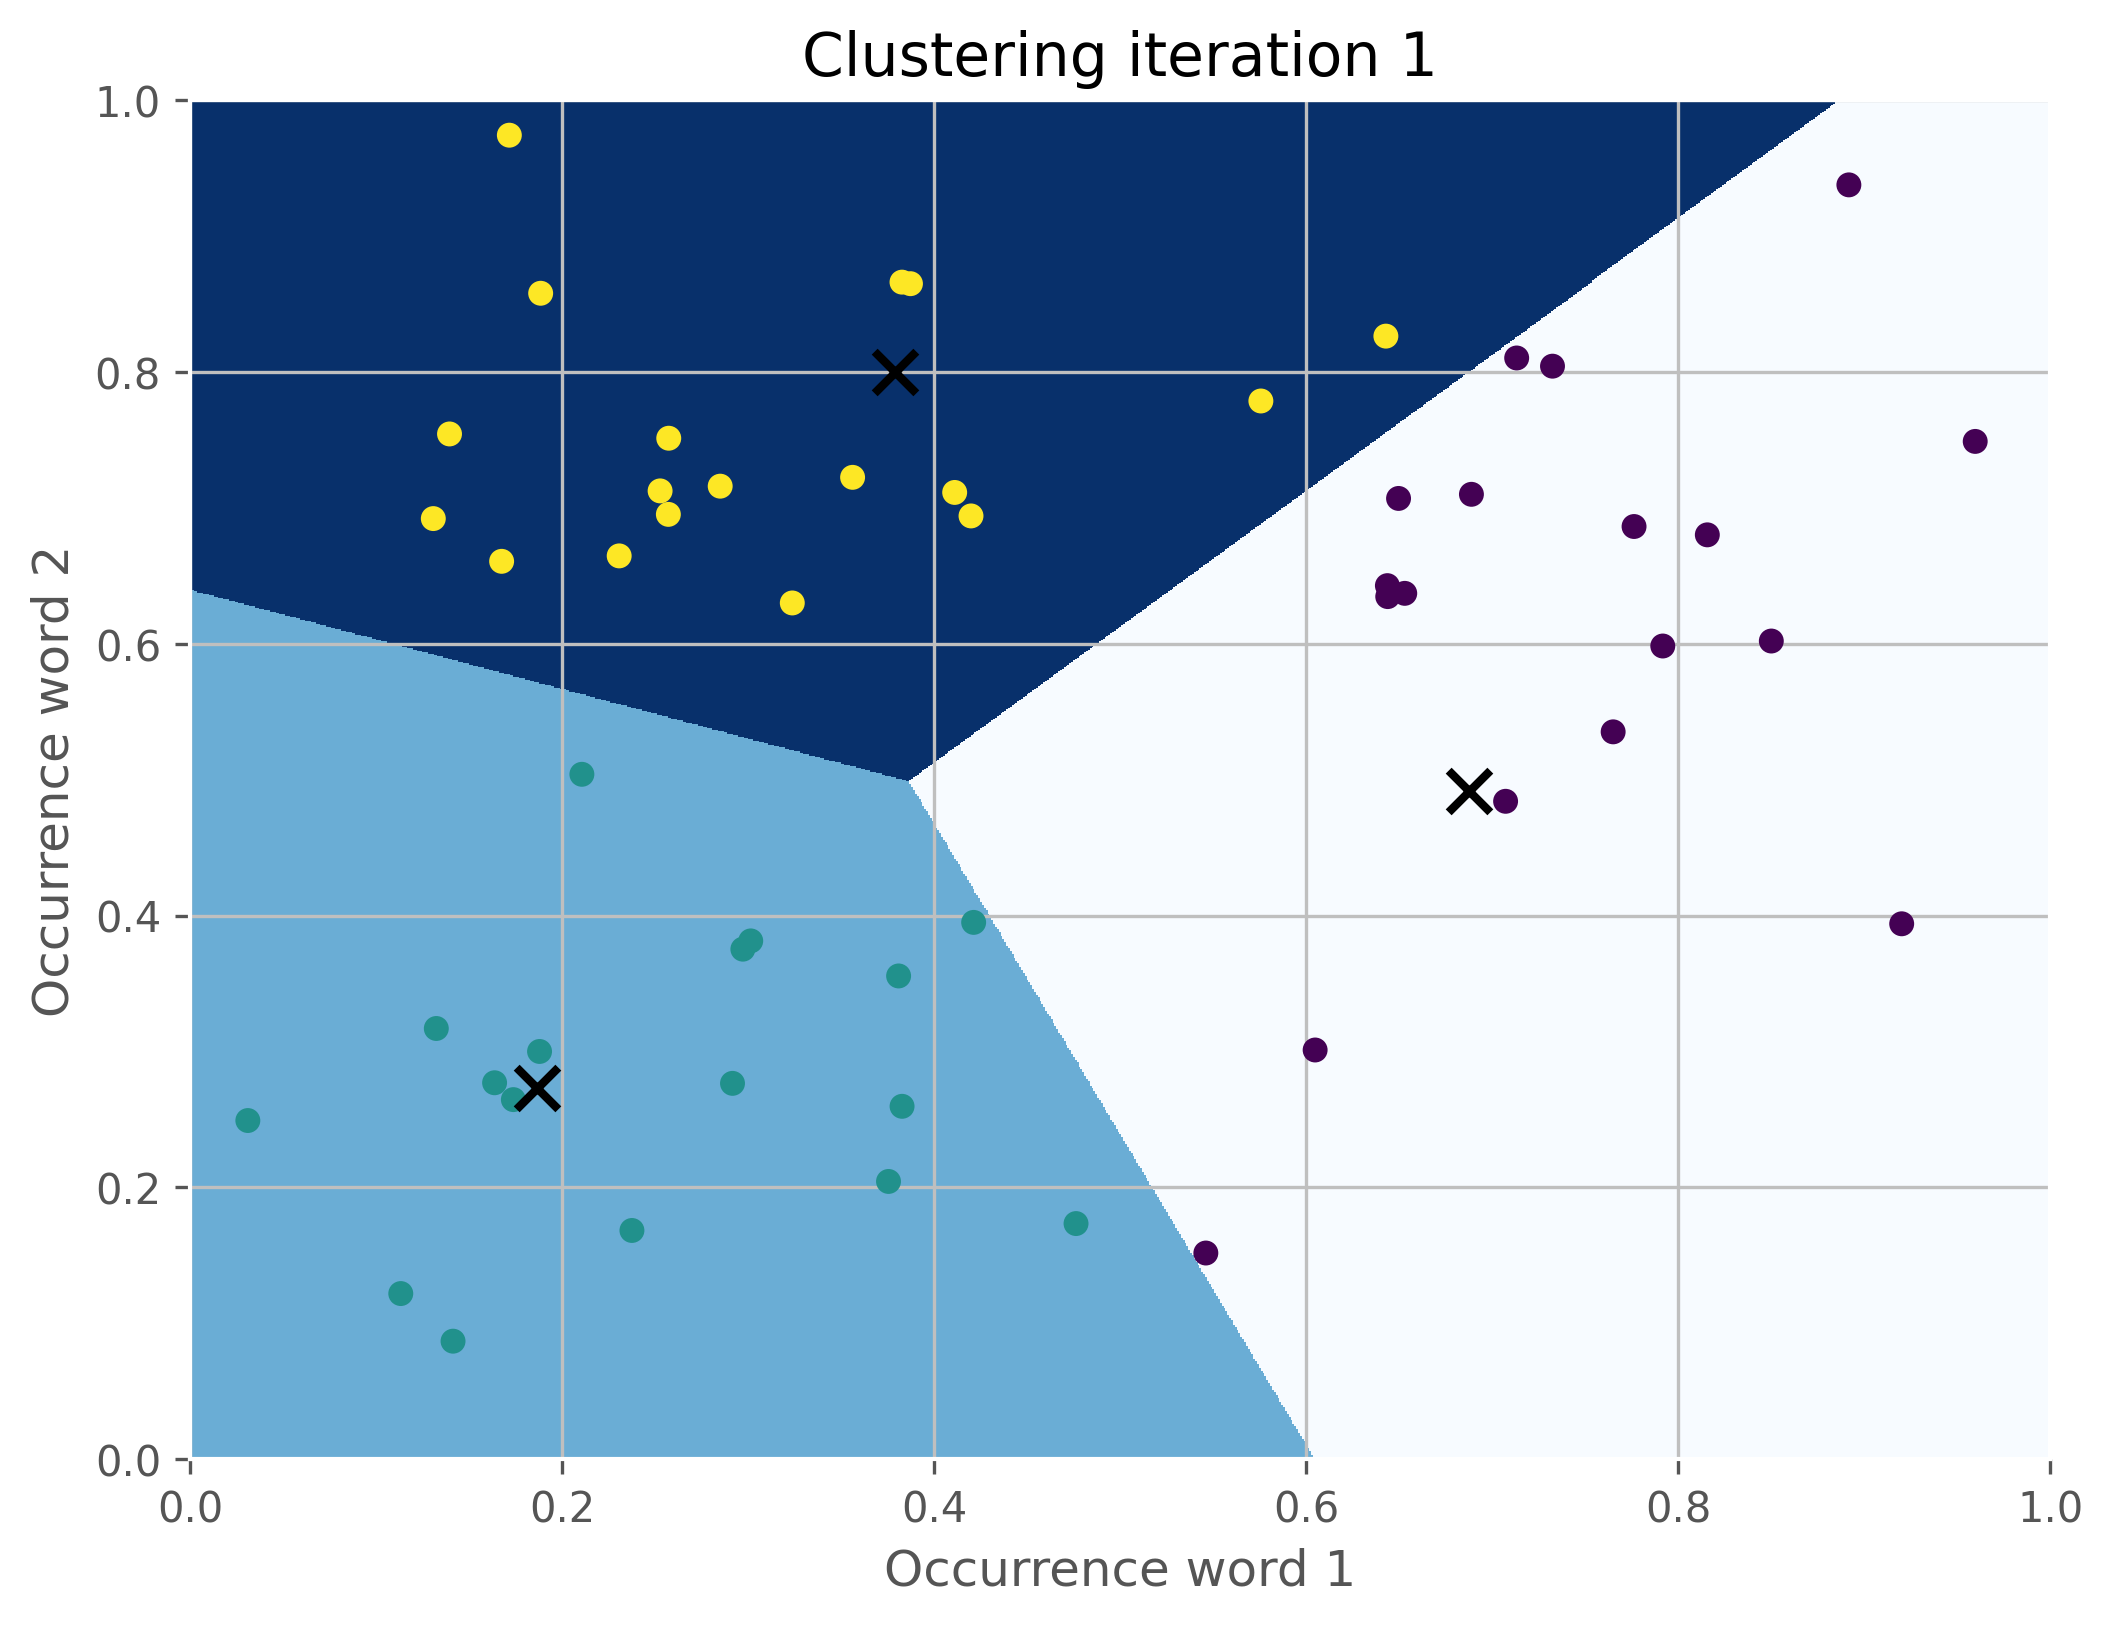

In [45]:
mx, my = np.meshgrid(np.arange(0, 1, 0.001), np.arange(0, 1, 0.001))

km = KMeans(
    init="random", 
    n_clusters=num_clusters, 
    verbose=1,
    n_init=1, 
    max_iter=1,
    random_state=seed
)

km.fit(np.array(list(zip(x, y))))

Z = km.predict(np.c_[mx.ravel(), my.ravel()]).reshape(mx.shape)

plot_clustering(x, y, "Clustering iteration 1", km=km)
plt.imshow(
    Z, 
    interpolation="nearest",
    extent=(mx.min(), mx.max(), my.min(), my.max()),
    cmap=plt.cm.Blues,
    aspect="auto",
    origin="lower"
)

c1a, c1b, c1c = km.cluster_centers_
plt.scatter(
    km.cluster_centers_[:, 0],
    km.cluster_centers_[:, 1],
    marker="x", 
    linewidth=2, 
    s=100, 
    color="black"
)
save_png("02_clustering_iteration_1")

## Clustering after 2nd iteration

Initialization complete
Iteration 0, inertia 4.748526747411677.
Iteration 1, inertia 3.378785693965447.


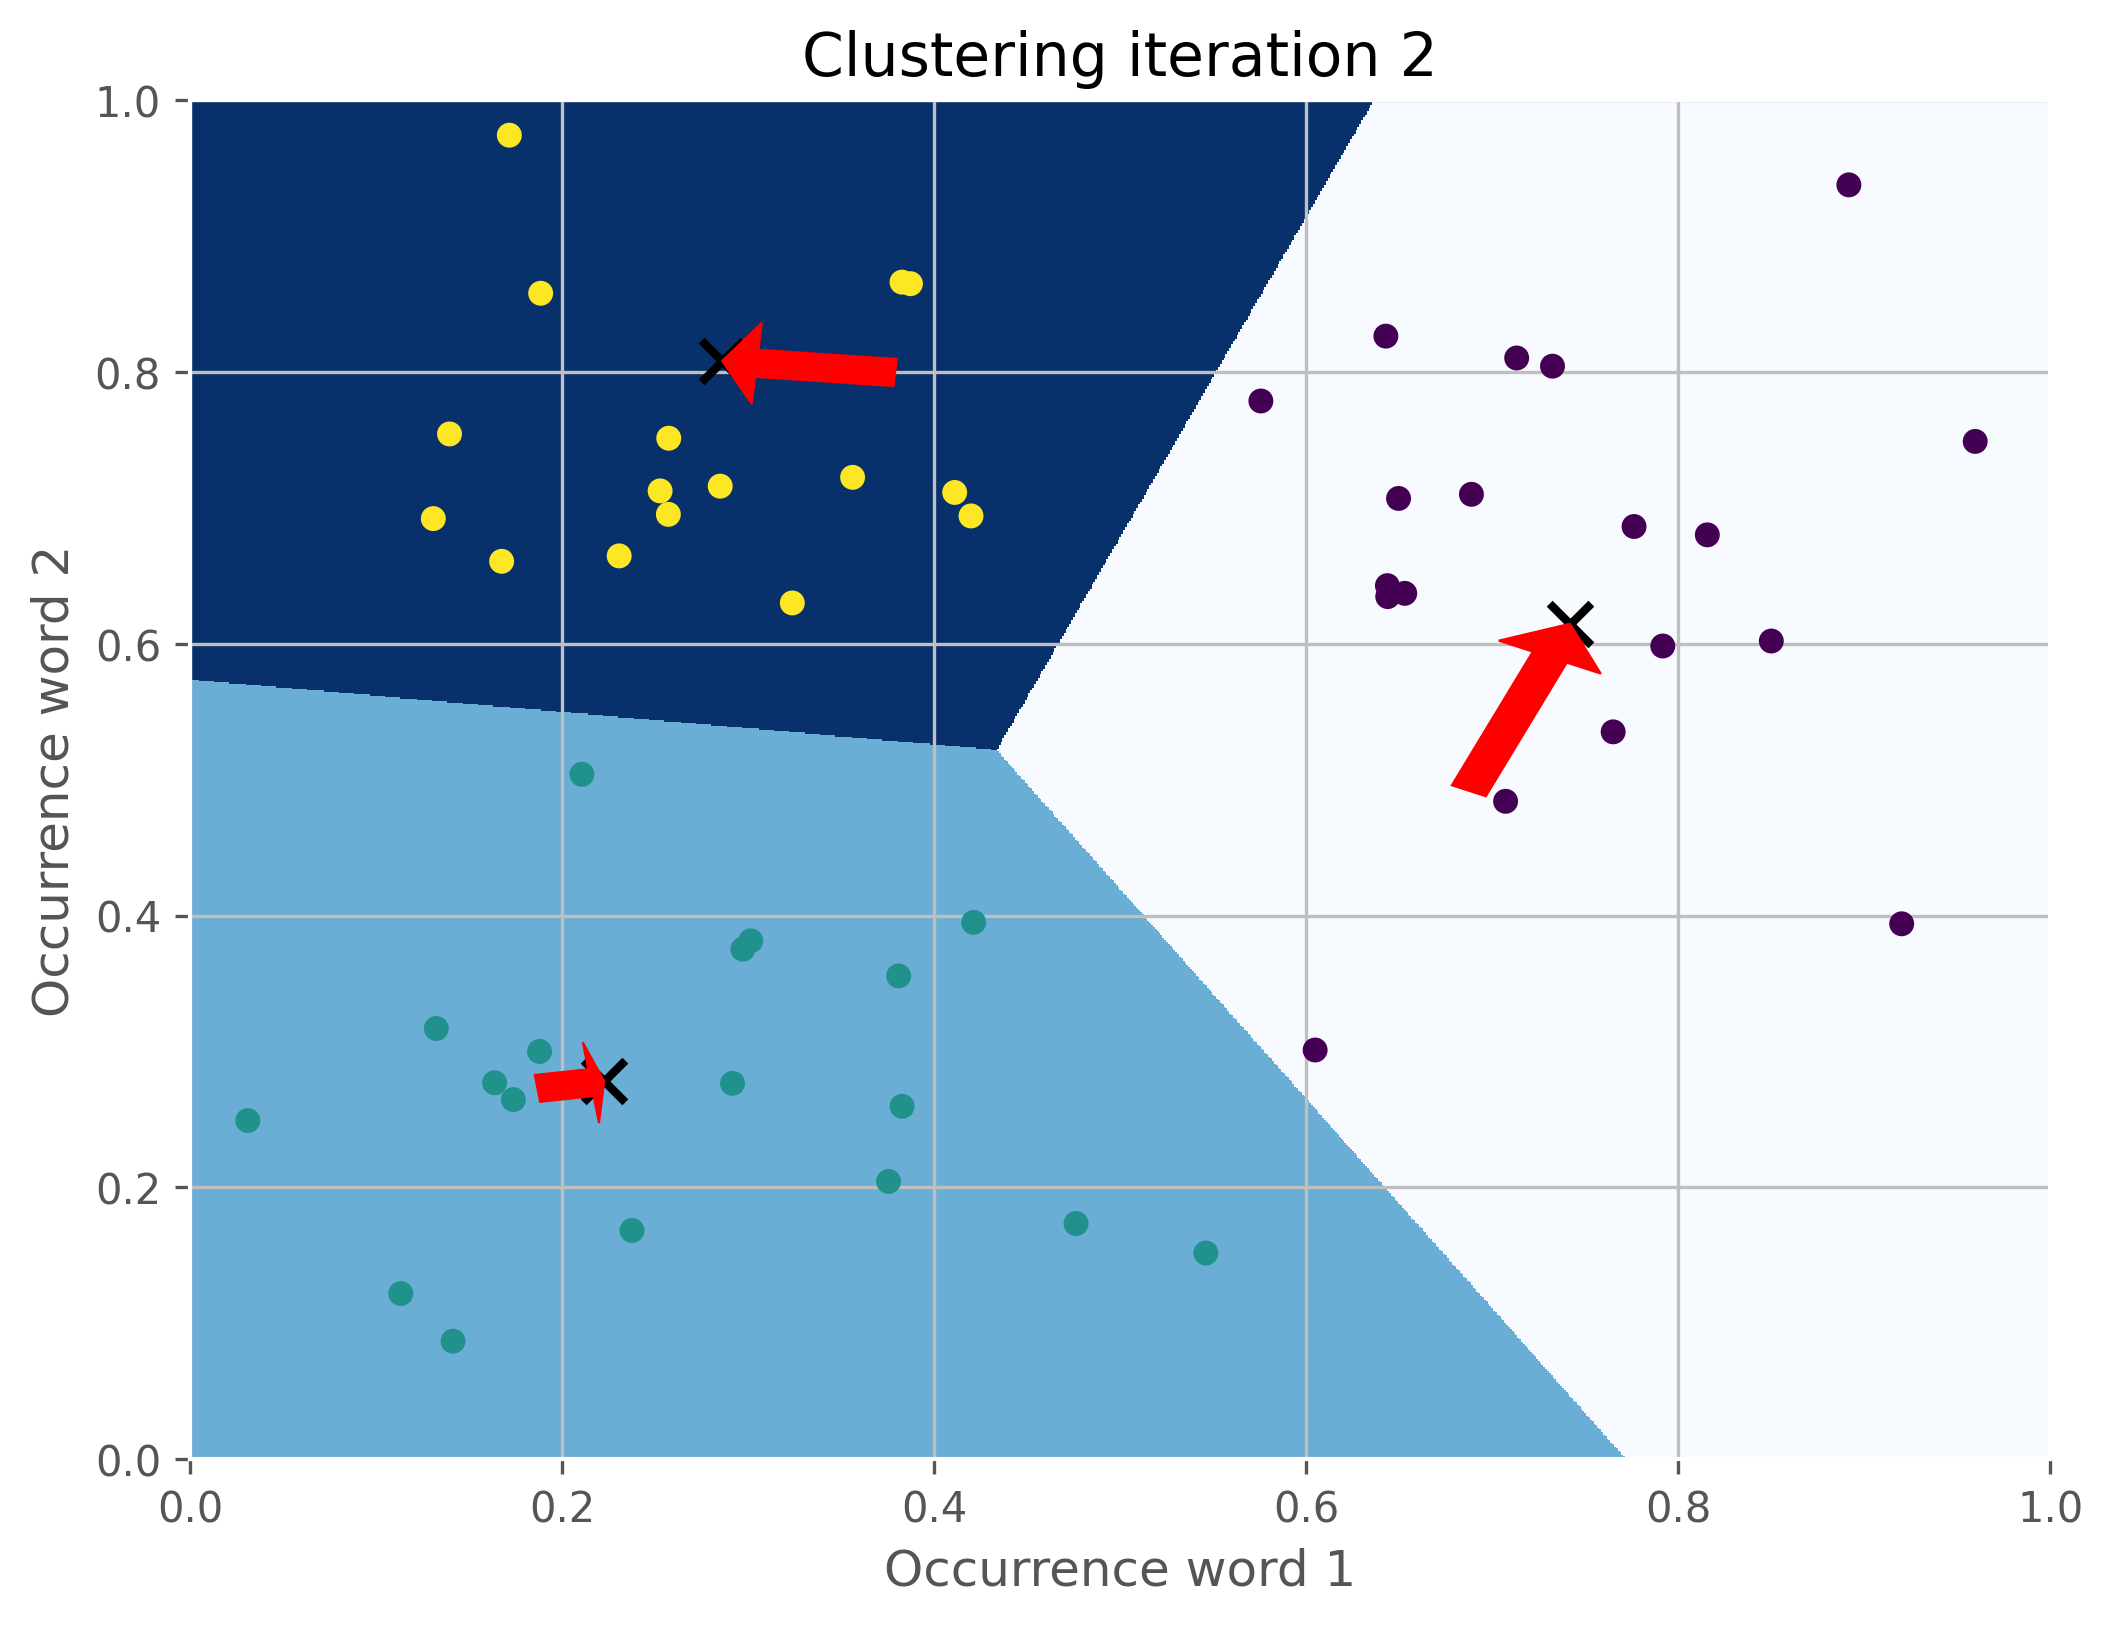

In [46]:
km = KMeans(
    init="random", 
    n_clusters=num_clusters, 
    verbose=1,
    n_init=1, 
    max_iter=2,
    random_state=seed
)
km.fit(np.array(list(zip(x, y))))

Z = km.predict(np.c_[mx.ravel(), my.ravel()]).reshape(mx.shape)

plot_clustering(x, y, "Clustering iteration 2", km=km)
plt.imshow(
    Z, 
    interpolation="nearest",
    extent=(mx.min(), mx.max(), my.min(), my.max()),
    cmap=plt.cm.Blues,
    aspect="auto",
    origin="lower"
)

c2a, c2b, c2c = km.cluster_centers_
plt.scatter(
    km.cluster_centers_[:, 0], 
    km.cluster_centers_[:, 1],
    marker="x", 
    linewidth=2, 
    s=100, 
    color="black"
)

plt.gca().add_patch(
    plt.Arrow(
        c1a[0], 
        c1a[1],
        c2a[0] - c1a[0], 
        c2a[1] - c1a[1], 
        width=0.1, 
        color="red"
    )
)
plt.gca().add_patch(
    plt.Arrow(
        c1b[0], 
        c1b[1], 
        c2b[0] - c1b[0], 
        c2b[1] - c1b[1], 
        width=0.1, 
        color="red"
    )
)
plt.gca().add_patch(
    plt.Arrow(
        c1c[0], 
        c1c[1], 
        c2c[0] - c1c[0], 
        c2c[1] - c1c[1], 
        width=0.1, 
        color="red"
    )
)

save_png("03_clustering_iteration_2")

## Final clustering (10 iterations)

Initialization complete
Iteration 0, inertia 4.748526747411677.
Iteration 1, inertia 3.3787856939654466.
Iteration 2, inertia 2.5999573206286968.
Iteration 3, inertia 2.496571140237421.
Iteration 4, inertia 2.447223016211801.
Converged at iteration 4: strict convergence.


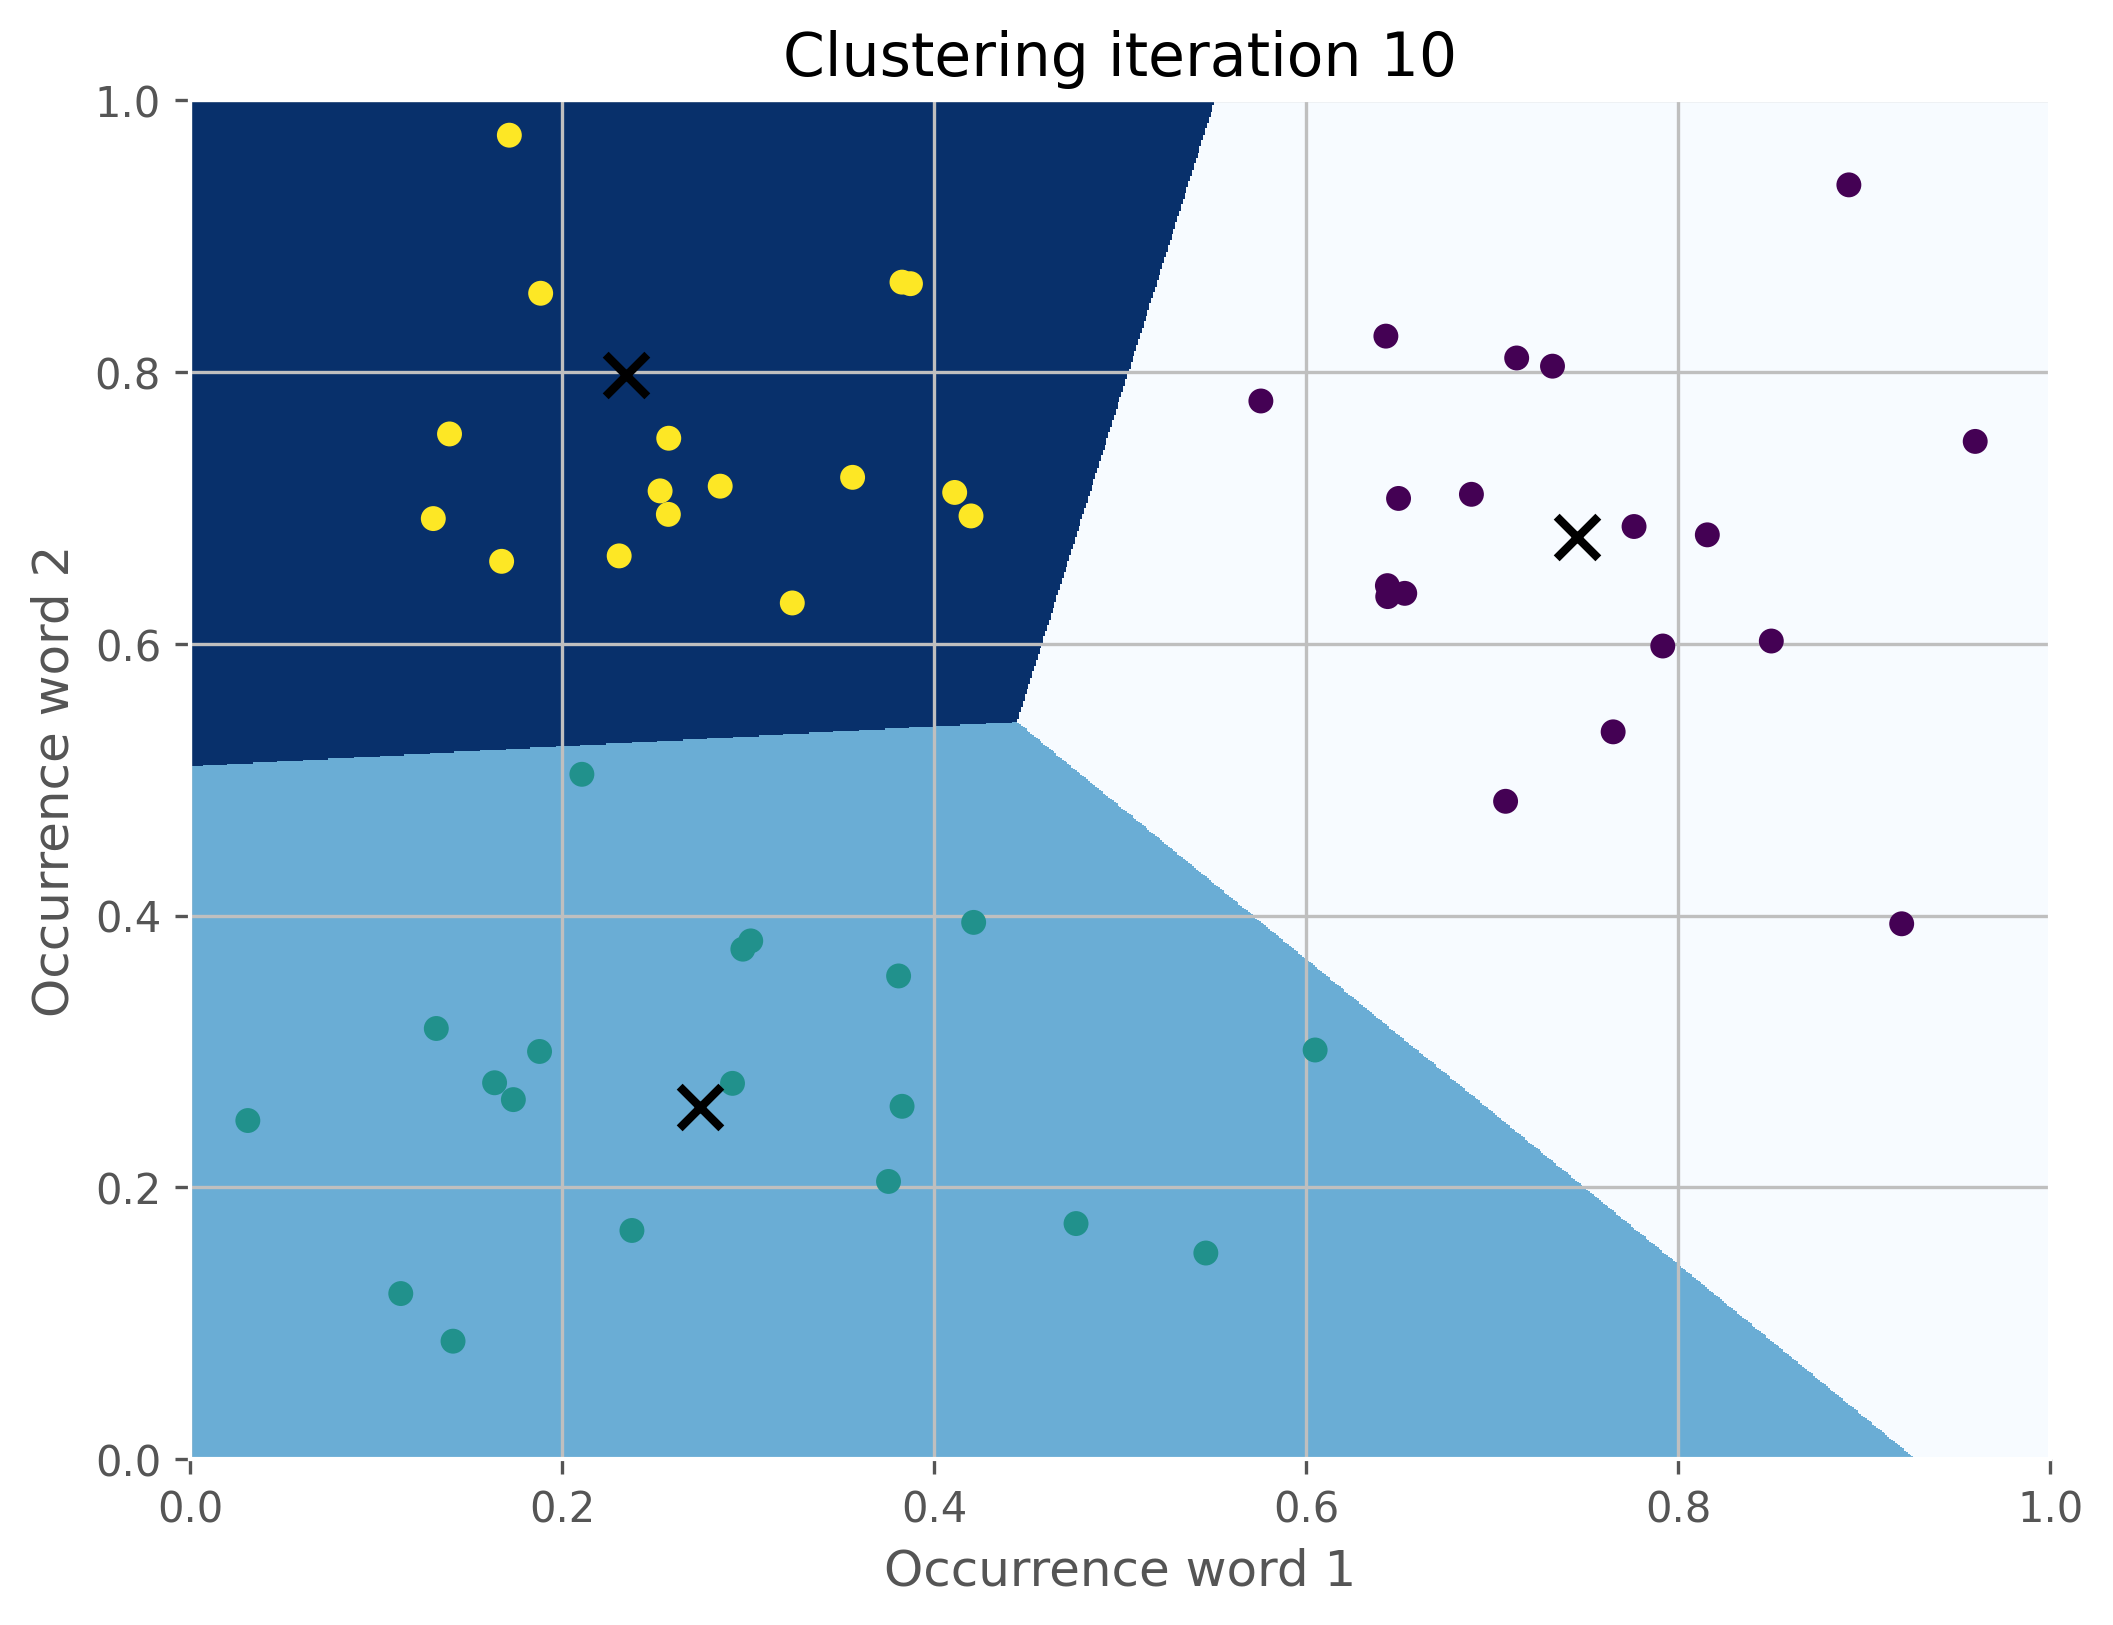

In [47]:
km = KMeans(
    init="random", 
    n_clusters=num_clusters, 
    verbose=1,
    n_init=1,
    max_iter=10,
    random_state=seed
)
km.fit(np.array(list(zip(x, y))))

Z = km.predict(np.c_[mx.ravel(), my.ravel()]).reshape(mx.shape)

plot_clustering(x, y, "Clustering iteration 10", km=km)
plt.imshow(
    Z, 
    interpolation="nearest",
    extent=(mx.min(), mx.max(), my.min(), my.max()),
    cmap=plt.cm.Blues,
    aspect="auto",
    origin="lower"
)

plt.scatter(
    km.cluster_centers_[:, 0], 
    km.cluster_centers_[:, 1],
    marker="x",
    linewidth=2,
    s=100, 
    color="black"
)
save_png("04_clustering_iteration_final")

### Testing our idea on real data

In [48]:
import sklearn.datasets
all_data = sklearn.datasets.fetch_20newsgroups(subset="all") 
print(len(all_data.filenames))
print(all_data.target_names)

18846
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [52]:
train_data = sklearn.datasets.fetch_20newsgroups(subset="train")
print(len(train_data.filenames))

test_data = sklearn.datasets.fetch_20newsgroups(subset="test")
print(len(test_data.filenames))

11314
7532


In [50]:
groups = ["comp.graphics", "comp.os.ms-windows.misc", "comp.sys.ibm.pc.hardware",
          "comp.sys.mac.hardware", "comp.windows.x", "sci.space"]

train_data = sklearn.datasets.fetch_20newsgroups(subset="train", categories=groups)
print(len(train_data.filenames))

test_data = sklearn.datasets.fetch_20newsgroups(subset="test", categories=groups)
print(len(test_data.filenames))

3529
2349


### Clustering posts 

In [51]:
vectorizer = StemmedTfidfVectorizer(
    min_df=10,
    max_df=0.5,
    stop_words='english',
    decode_error='ignore'
)
vectorized = vectorizer.fit_transform(train_data.data)

num_samples, num_features = vectorized.shape
print(f"#samples: {num_samples}, #features: {num_features}")

#samples: 3529, #features: 4712


In [53]:
num_clusters = 50

km = KMeans(
    n_clusters=num_clusters, 
    n_init=1, 
    verbose=1, 
    random_state=3
)
clustered = km.fit(vectorized)

Initialization complete
Iteration 0, inertia 5686.052543663706.
Iteration 1, inertia 3164.8875140123555.
Iteration 2, inertia 3132.207711195148.
Iteration 3, inertia 3111.7125758781394.
Iteration 4, inertia 3098.583773647868.
Iteration 5, inertia 3092.1905280374403.
Iteration 6, inertia 3087.2770892443095.
Iteration 7, inertia 3084.100477377272.
Iteration 8, inertia 3082.7997677507.
Iteration 9, inertia 3082.23438261742.
Iteration 10, inertia 3081.948798416203.
Iteration 11, inertia 3081.843333964576.
Iteration 12, inertia 3081.7906650371283.
Iteration 13, inertia 3081.7522177638266.
Iteration 14, inertia 3081.6597186798836.
Iteration 15, inertia 3081.616791469511.
Iteration 16, inertia 3081.589484298167.
Iteration 17, inertia 3081.5709703035714.
Converged at iteration 17: strict convergence.


In [54]:
print(f"km.labels_={km.labels_}")
print(f"km.labels_.shape={km.labels_.shape}")

km.labels_=[48 23 31 ...  6  2 22]
km.labels_.shape=(3529,)


In [55]:
new_post = '''\
Disk drive problems. Hi, I have a problem with my hard disk.
After 1 year it is working only sporadically now.
I tried to format it, but now it doesn't boot any more.
Any ideas? Thanks.
'''

new_post_vec = vectorizer.transform([new_post])
new_post_label = km.predict(new_post_vec)[0]

similar_indices = (km.labels_ == new_post_label).nonzero()[0]

similar = []
for i in similar_indices:
    dist = scipy.linalg.norm((new_post_vec - vectorized[i]).toarray())
    similar.append((dist, train_data.data[i]))

In [56]:
similar = sorted(similar)
print(f"Count similar: {len(similar)}")

show_at_1 = similar[0]
show_at_2 = similar[len(similar) // 10]
show_at_3 = similar[len(similar) // 2]

print("=== #1 ===")
print(show_at_1)
print()

print("=== #2 ===")
print(show_at_2)
print()

print("=== #3 ===")
print(show_at_3)

Count similar: 56
=== #1 ===
(1.0378441731334074, 'From: dbernard@clesun.Central.Sun.COM (Dave Bernard)\nSubject: Re: Ax the ATF\nOrganization: Sun Microsystems\nLines: 14\nDistribution: world\nReply-To: dbernard@clesun.Central.Sun.COM\nNNTP-Posting-Host: clesun.central.sun.com\n\n>True, Congress has said that possesion of an unlicensed automatic \n>weapon is a violation of the law.  Congress did not, however, say\n>that such possesion was a capital offense or a transgression worth\n>getting four good government agents killed and 16 others wounded.\n\n\nEven if it were a capital offense, the warrant was not even an arrest warrant,\nbut a search warrant.  In other words, there was no evidence of illegal\narms, just enough of a suggestion to get a judge to sign a license to\nsearch for illegal evidence.\n\nQuestion:  As in the Rodney King case, will the US DOJ institute\ncriminal civil rights proceedings against the BATF?  Or at least an\ninvestigation?  OK, sorry I asked.\n')

=== #2 ==

In [57]:
post_group = zip(train_data.data, train_data.target)

all = [(len(post[0]), post[0], train_data.target_names[post[1]])
       for post in post_group]
graphics = sorted([post for post in all if post[2] == "comp.graphics"])
print(graphics[5])

(245, 'From: SITUNAYA@IBM3090.BHAM.AC.UK\nSubject: test....(sorry)\nOrganization: The University of Birmingham, United Kingdom\nLines: 1\nNNTP-Posting-Host: ibm3090.bham.ac.uk\n\n==============================================================================\n', 'comp.graphics')


In [58]:
noise_post = graphics[5][1]

analyzer = vectorizer.build_analyzer()
print(list(analyzer(noise_post)))

['situnaya', 'ibm3090', 'bham', 'ac', 'uk', 'subject', 'test', 'sorri', 'organ', 'univers', 'birmingham', 'unit', 'kingdom', 'line', 'nntp', 'post', 'host', 'ibm3090', 'bham', 'ac', 'uk']


In [59]:
useful = set(analyzer(noise_post)).intersection(vectorizer.get_feature_names_out())
print(sorted(useful))

['ac', 'birmingham', 'host', 'kingdom', 'nntp', 'sorri', 'test', 'uk', 'unit', 'univers']


In [60]:
for term in sorted(useful):
    print("IDF({}) = {:.2f}".format(term, vectorizer._tfidf.idf_[vectorizer.vocabulary_[term]]))

IDF(ac) = 3.51
IDF(birmingham) = 6.77
IDF(host) = 1.74
IDF(kingdom) = 6.68
IDF(nntp) = 1.77
IDF(sorri) = 4.14
IDF(test) = 3.83
IDF(uk) = 3.70
IDF(unit) = 4.42
IDF(univers) = 1.91
